In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.callbacks import TQDMProgressBar

%run ../gridsearch/xception.ipynb

In [4]:
# Load denoised log-images
basedir = Path("../../")
dataset = basedir / "./data/data_v1d.npz"
modelpath = "./models/rdn_xception.tf"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    image = data["img_denoised"]
    label = data["label"]

Available variables: ['img_log_denoised', 'label', 'psf_r', 'snr', 'sigma']


In [5]:
# Use unscaled images. Let TF normalize the data.
X = image[..., np.newaxis]
input_shape = X.shape[1:]

# Scale the labels between -1 and 1 using the full dataset. We know the ranges of generated labels.
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(label)
output_shape = y.shape[1:]

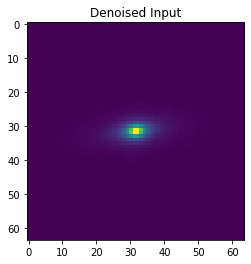

In [6]:
plt.imshow(X[0].reshape(64, 64))
plt.title("Denoised Input");

In [7]:
# Build a small Xception model
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8
)
model.compile(optimizer=Adam(0.0001), loss="mse")

# Adapt the normalization layer to the data
adapt_model(model, X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 1)    3           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   416         normalization[0][0]              
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 64)   1232        conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
# Setup callbacks
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
tqdm_callback = TQDMProgressBar()
checkpoint = ModelCheckpoint(modelpath, save_best_only=True)

# Train the model on the full dataset
history = model.fit(
    X,
    y,
    batch_size=32,
    epochs=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[early_stopping, tqdm_callback, checkpoint],
)
model.save(modelpath)

Epoch 1/1000



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 2/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 3/1000



Epoch 4/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 5/1000



Epoch 6/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 7/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 8/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 9/1000



Epoch 10/1000



Epoch 11/1000



Epoch 12/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 13/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 14/1000



Epoch 15/1000



Epoch 16/1000



Epoch 17/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 18/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 19/1000



Epoch 20/1000



Epoch 21/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 22/1000



Epoch 23/1000



Epoch 24/1000



Epoch 25/1000



Epoch 26/1000



Epoch 27/1000



Epoch 28/1000



Epoch 29/1000



Epoch 30/1000



Epoch 31/1000



Epoch 32/1000



Epoch 33/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 34/1000



Epoch 35/1000



Epoch 36/1000



Epoch 37/1000



Epoch 38/1000



Epoch 39/1000



Epoch 40/1000



Epoch 41/1000



Epoch 42/1000



Epoch 43/1000



Epoch 44/1000



Epoch 45/1000



Epoch 46/1000



INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets
Epoch 47/1000



Epoch 48/1000



Epoch 49/1000



Epoch 50/1000



Epoch 51/1000



Epoch 52/1000



Epoch 53/1000



Epoch 54/1000



Epoch 55/1000



Epoch 56/1000



Epoch 57/1000



Epoch 58/1000



Epoch 59/1000



Epoch 60/1000



Epoch 61/1000



Epoch 62/1000



Epoch 63/1000



Epoch 64/1000



Epoch 65/1000



Epoch 66/1000




INFO:tensorflow:Assets written to: ./models/rdn_xception.tf/assets


In [9]:
# Evaluate the model on the validation set
n_train = int(label.shape[0] * 0.9)
X_val = X[n_train:]
label_val = label[n_train:]

# Predict the labels and convert them to the original scale
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Compute RMSE for each label individually
np.set_printoptions(suppress=True)
rmse = np.sqrt(((label_val - predictions)**2).mean(axis=0))
rmse

array([5577.07      ,    0.76942104,    0.04580465,    0.07094237,
          0.07122599], dtype=float32)